# Capstone Project 
### Data Engineering Capstone Project

#### Project Summary
This project follows the Udacity proivided project, which will combine various datasets. I have chosen to combine data on US immigration with supplimentary data based on US City demographics. It is also combined with dimensional data enriched from a dictionary file. This results in a small star schema data model which can be used to analyse immigration trends over the period of the data provided.
The immigration data used has more than one million rows and so consideration is given to the efficiency of loading this data into the star schema. 

The project follows the following steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [3]:
# imports and installs
import pandas as pd

### Step 1: Scope the Project and Gather Data

#### Scope 
The scope of this project will be to gather and describe immigration data with supporting dimensional data, so that a small star schema based data warehouse can be created. The end solution and purpose of the final data model would be that this small data warehouse could be used to query immigration trends and summaries based around demographics and other dimensions such as by country or port or mode of travel, etc. 

The data used in this project is as follows:
- I94 Immigration Data: This data comes from the US National Tourism and Trade Office (parquet files)
- The data disctionary data for the above I94 Immigration Data data (sas file)
- U.S. City Demographic Data: This data comes from OpenSoft (csv file)

The tools used in the project are:
- Jupyter notebook for structuring and performing the data analysis, exploration and assessment. Also this was used for defining and planning the pipelines necessary to take the raw data and transform it into the star schema data warehouse. The notebook was a good way planning the porject as well as being able to write small code snippets that would contribute to the end solution.
- Airflow to orchestrate the ETL pipeline. This tool is excellent at coordinating the tasks involved in the ETL pipeline and is justified by also allowing for several tasks being able to be executed in parallel at once.
- Python to code the ETL process
- VS Studio Code to help write the ETL progress. This tool helped me write the pythin code, especially with syntax highlighting
- Anaconda local installation for the development environment. This environment worked alongside my jupyter notebook.
- Docker to test the airflow pipeline locally. This provided the runtime environment for my local airflow installation, where I could see all the logs generated, etc.
- AWS S3 to host the raw input data. Since the fact data is a large dataset, it seemed best to me to store it on S3 to allow for it to be staged directly to Redshift with minimal delay, Supporting files are also stored here.
- AWS Redshift to host the star schema data warehouse. This is justified by its scalability and ease of use. If it was necessary to process a larger amount of data then Redshift can be scaled up by adding more nodes.
- Excel to help visualise the data and look for data quality issues



#### Describe and Gather Data 
 
Dimension data is going to come from the I94_SAS_Labels_Descriptions.SAS file  
i94cntyl / i94cit / i94res - dimension data - Countries   
i94prtl - port within state   
i94mode - mode of travel   
i94addrl - states   
i94visa - travel visa   

Further dimension data is going to come from the us-cities-demographics.csv file. This data is grouped by State, City and Race. It shows population data broken down at this level. 


In [81]:
def extract_key_values(value): 
    value_found = False
    key_codes_list = []
    key_values_list = []

    with open('I94_SAS_Labels_Descriptions.SAS','r') as reader:
        for line in reader:
            if value in line:
                value_found=True
            if value_found and '=' in line:
                key_code, val = line.split('=')
                key_code = key_code.strip()
                key_val = val.strip()
                key_val = key_val.replace(";","")
                key_val = key_val.replace("'","")
                key_code = key_code.replace("'","")
                key_codes_list.append(key_code)
                key_values_list.append(key_val)
                if ';' in line:
                    break
            else:
                if value_found and ';' in line:
                    break     
    
    df = pd.DataFrame(list(zip(key_codes_list,key_values_list)))
    df.columns = ['key_code', 'key_value']
    df = df.astype(str)
    
    return df



In [62]:
i94cntyl = extract_key_values('i94cntyl')

In [63]:
i94cntyl

,key_code,key_value
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA
...,...,...
284,791,No Country Code (791)
285,849,No Country Code (849)
286,914,No Country Code (914)
287,944,No Country Code (944)


In [64]:
i94prtl = extract_key_values('i94prtl')

In [65]:
i94prtl

,key_code,key_value
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"
...,...,...
655,ADU,No PORT Code (ADU)
656,AKT,No PORT Code (AKT)
657,LIT,No PORT Code (LIT)
658,A2A,No PORT Code (A2A)


In [20]:
i94model = extract_key_values('i94model')

In [71]:
i94model

,key_code,key_value
0,1,Air
1,2,Sea
2,3,Land
3,9,Not reported


In [69]:
i94addrl = extract_key_values('i94addrl')

In [70]:
i94addrl

,key_code,key_value
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA
5,CO,COLORADO
6,CT,CONNECTICUT
7,DE,DELAWARE
8,DC,DIST. OF COLUMBIA
9,FL,FLORIDA


In [82]:
i94visal = extract_key_values('I94VISA')

In [83]:
i94visal

,key_code,key_value
0,1,Business
1,2,Pleasure
2,3,Student


In [24]:
demographics_df = pd.read_csv('us-cities-demographics.csv', sep=';')

In [25]:
demographics_df.head(10)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
5,Peoria,Illinois,33.1,56229.0,62432.0,118661,6634.0,7517.0,2.40,IL,American Indian and Alaska Native,1343
6,Avondale,Arizona,29.1,38712.0,41971.0,80683,4815.0,8355.0,3.18,AZ,Black or African-American,11592
7,West Covina,California,39.8,51629.0,56860.0,108489,3800.0,37038.0,3.56,CA,Asian,32716
8,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Hispanic or Latino,2583
9,High Point,North Carolina,35.5,51751.0,58077.0,109828,5204.0,16315.0,2.65,NC,Asian,11060


In [26]:
demographics_df.dtypes

City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
dtype: object

### Step 2: Explore and Assess the Data
#### Explore the Data 



#### Cleaning Steps
Steps necessary to clean the data (Cleaning will be performed in the ETL pipeline)

##### Dimension Data:

i94cntyl / i94cit / i94res - dimension data - Countries - remove "INVALID", "Collapsed","No Country Code"

$i94prtl - port within state - remove "Collapsed", "No PORT Code"

i94mode - mode of travel - looks ok

i94addrl - states - remove "All Other Codes"

i94visa - travel visa - looks ok

us-cities-demographics
Data is grouped by state, city and race. State is in the fact table, so this will be a foreign key on the fact table.  Other than that, the data looks complete with no need for cleaning


In [44]:
i94cntyl = i94cntyl [i94cntyl["key_value"].str.contains("No Country Code") == False]

In [45]:
i94cntyl = i94cntyl [i94cntyl["key_value"].str.contains("Collapsed") == False]

In [46]:
i94cntyl = i94cntyl [i94cntyl["key_value"].str.contains("INVALID") == False]

In [47]:
i94cntyl

,key_code,key_value
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA
...,...,...
231,216,YEMEN
232,139,YUGOSLAVIA
233,301,ZAIRE
234,344,ZAMBIA


In [66]:
i94prtl = i94prtl [i94prtl["key_value"].str.contains("Collapsed") == False]

In [67]:
i94prtl = i94prtl [i94prtl["key_value"].str.contains("No PORT Code") == False]

In [68]:
i94prtl

,key_code,key_value
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"
...,...,...
586,MLI,"MOLINE, IL"
587,RIV,"RIVERSIDE, CA"
588,RME,"ROME, NY"
589,VNY,"VAN NUYS, CA"


In [74]:
i94addrl = i94addrl [i94addrl["key_value"].str.contains("All Other Codes") == False]

In [75]:
i94addrl

,key_code,key_value
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA
5,CO,COLORADO
6,CT,CONNECTICUT
7,DE,DELAWARE
8,DC,DIST. OF COLUMBIA
9,FL,FLORIDA


#### Fact Data
The fact data is based upon the parquet files in the sas_data directory  
Sample data has been provided in immigration_data_sample.csv


In [88]:
immigration_df = pd.read_csv('immigration_data_sample.csv', sep=',')

In [89]:
immigration_df

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2117909,4288772.0,2016.0,4.0,135.0,135.0,LVG,20567.0,1.0,NV,...,NaN,M,1984.0,07212016,M,NaN,VS,5.914065e+10,00043,WT
996,1463022,2947585.0,2016.0,4.0,261.0,261.0,PSP,20560.0,1.0,HI,...,NaN,M,1981.0,10152016,M,NaN,SV,9.371186e+10,00041,B1
997,1414569,2883298.0,2016.0,4.0,111.0,111.0,MIA,20560.0,1.0,FL,...,NaN,M,1977.0,07142016,M,NaN,AF,5.627747e+10,00090,WT
998,1094181,2264857.0,2016.0,4.0,582.0,582.0,ATL,20556.0,1.0,WI,...,NaN,M,1981.0,10112016,M,NaN,EV,9.334035e+10,05510,B1


In [87]:
immigration_df.dtypes

Unnamed: 0      int64
cicid         float64
i94yr         float64
i94mon        float64
i94cit        float64
i94res        float64
i94port        object
arrdate       float64
i94mode       float64
i94addr        object
depdate       float64
i94bir        float64
i94visa       float64
count         float64
dtadfile        int64
visapost       object
occup          object
entdepa        object
entdepd        object
entdepu       float64
matflag        object
biryear       float64
dtaddto        object
gender         object
insnum        float64
airline        object
admnum        float64
fltno          object
visatype       object
dtype: object

#### Cleaning of Fact data
It can be notcied that gender is either missing or is not "M" or "F" (i.e. is unknown). Since gender is required for demographics analysis, these entries will be dropped. This data will be dropped post loading into the redshift table because due to the size, I do not want to load this data into pandas dataframes. These entries will be 'cleaned' post loading to the fact table which I believe to be the most efficient. It would be possible to add further cleaning steps on the fact data at a later time, such as removing entries which have a missing state. 

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Reason for choosing this model  
Fact data is immigration data. It will have the following dimensions, so that reports can be run to get statistics based on the following groupings:  
    1. Mode of Travel  
    2. State  
    3. Country  
    4. Travel Visa  
    5. Port  
    
An extra dimension is going to be added based upon state demographics. This will allow for the construction of state based statistics with a demographic element, such as male, female and total population and foreign born. This could be used to find demographic correlations in the data such as percentages of state immigration based upon population. 

#### 3.2 Mapping Out Data Pipelines
There are the steps necessary to pipeline the data into the chosen data model  

The steps will be run by airflow in a DAG.  

#### Prerequisits
- Immigration parquest files are to be uploaded into an S3 bucket in advance  
- The files "us-cities-demographics.csv" and I94_SAS_Labels_Descriptions.SAS supporting files will also be uploaded and made available in the same S3 bucket  

1. Stage immigration parquet files from S3 into fact_immigration table
2. In parallel with the above, load the dimension tables by transforming the data in the supporting files 
3. Once the fact and dimension tables are loaded, perform data cleansing processes (in SQL) on them
4. Once all data cleansing processes are complete, perform data quality checks on the fact and dimension tables
5. The successful end of the pipeline will be when all data quality checks are passed.


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### See code in this repository

dags/etl_immigration_dag.py  

plugins/helpers/sql_queries.py  
plugins/operators/data_clean.py  
plugins/operators/data_quality.py  
plugins/operators/load_dimensions.py  
plugins/operators/stage_redshift.py  


#### 4.2 Data Quality Checks
 * Seven data quality checks are run, one for each loaded table, to ensure none are empty 
 

In [ ]:
# Quality checked are perfomed in the DAG code

#### 4.3 Data dictionary 
The data dictionary is shown below.


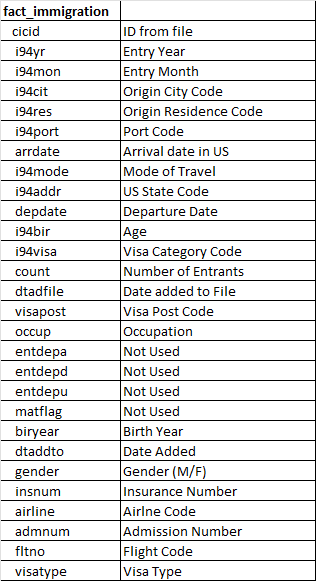


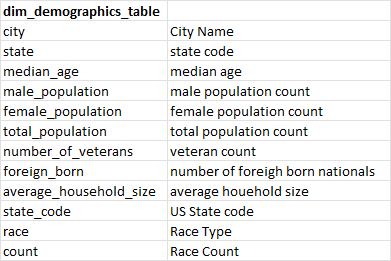

The other dimension tables are descriptive key/values of the respective data items in the fact table.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.  
  
    
    
 
**See project readme file where these points are documented**